In [ ]:
from time import time
import math, os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.version

from model import Autoencoder
import numpy as np
import pandas as pd
import collections
from sklearn import metrics
import scanpy as sc
import matplotlib.pyplot as plt

import optuna

In [ ]:
adata = sc.read_h5ad('../data/gene_sorted_filtered_matrix.h5ad').T
barcodes = pd.read_csv('../data/barcodes_filtered.tsv', header=None, sep='\t')
genes = pd.read_csv('../data/genes.tsv', header=None, sep='\t')
ground_truth_labels = pd.read_csv('../data/ground_truth_labels.tsv', sep='\t')

In [ ]:
# following scdeepcluster here, encoding labels to ints and attaching to the anndata object

adata.obs_names = barcodes[0].values
adata.var_names = genes[0].values

ground_truth_labels = ground_truth_labels.set_index("NAME")  
y = pd.Categorical(adata.obs_names.map(ground_truth_labels["New_cellType"])).codes

adata.obs['Group'] = y

In [ ]:
# standard filtering from scanpy workflow, this is also what our baseline used, we could consider tweaking this though

sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape)
print(adata.n_vars)

In [ ]:
# ZINB loss uses size factors and raw X values
# after saving those, normalize counts

adata.obs['n_counts'] = adata.X.sum(axis=1).A1  
adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)

adata.X = adata.X.toarray()

adata.raw = adata.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
# setting model args, defaults from scdeepcluster
# hyperparameter tuning on these?

input_dim = adata.n_vars
encoder_layers = [256, 64]
z_dim = 32
decoder_layers = [64, 256]

if (torch.cuda.is_available()):
    device = 'cuda'
else: 
    device = 'cpu'

print(f"Using {device}")


In [ ]:
# build model

model = Autoencoder(input_dim=adata.n_vars, z_dim=z_dim, encoder_layers=encoder_layers, decoder_layers=decoder_layers, device=device)
print(str(model))

In [8]:
# load pretrained weights if they exist, otherwise do pretraining step

if os.path.isfile('AE_weights.pth.tar'):
    print("Loading pretrained model weights")
    checkpoint = torch.load('AE_weights.pth.tar')
    model.load_state_dict(checkpoint['ae_state_dict'])
else:
    model.pretrain(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors)

Loading pretrained model weights


In [9]:
pretrain_latent = model.encodeBatch(torch.tensor(adata.X, dtype=torch.float64)).cpu().numpy()
adata_latent = sc.AnnData(pretrain_latent)

In [10]:
# Extremely slow on windows due to exception throwing, so store as file
if os.path.isfile('adata_latent.h5ad'):
    print("Loading pre-computed adata_latent")
    adata_latent = sc.read_h5ad('adata_latent.h5ad')
else:
    sc.pp.neighbors(adata_latent)
    sc.tl.leiden(adata_latent, flavor="igraph", n_iterations=2, resolution=0.3)
    adata_latent.write('adata_latent.h5ad')

Loading pre-computed adata_latent


In [11]:
# adata = adata_latent
# adata.obs['Group'] = y

# Extremely slow on windows due to exception throwing, so store as file
if os.path.isfile('adata.h5ad'):
    print("Loading pre-computed adata")
    adata = sc.read_h5ad('adata.h5ad')
else:
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.8)
    adata.write('adata.h5ad')

Loading pre-computed adata


In [12]:
sc.tl.umap(adata_latent)
sc.tl.umap(adata)

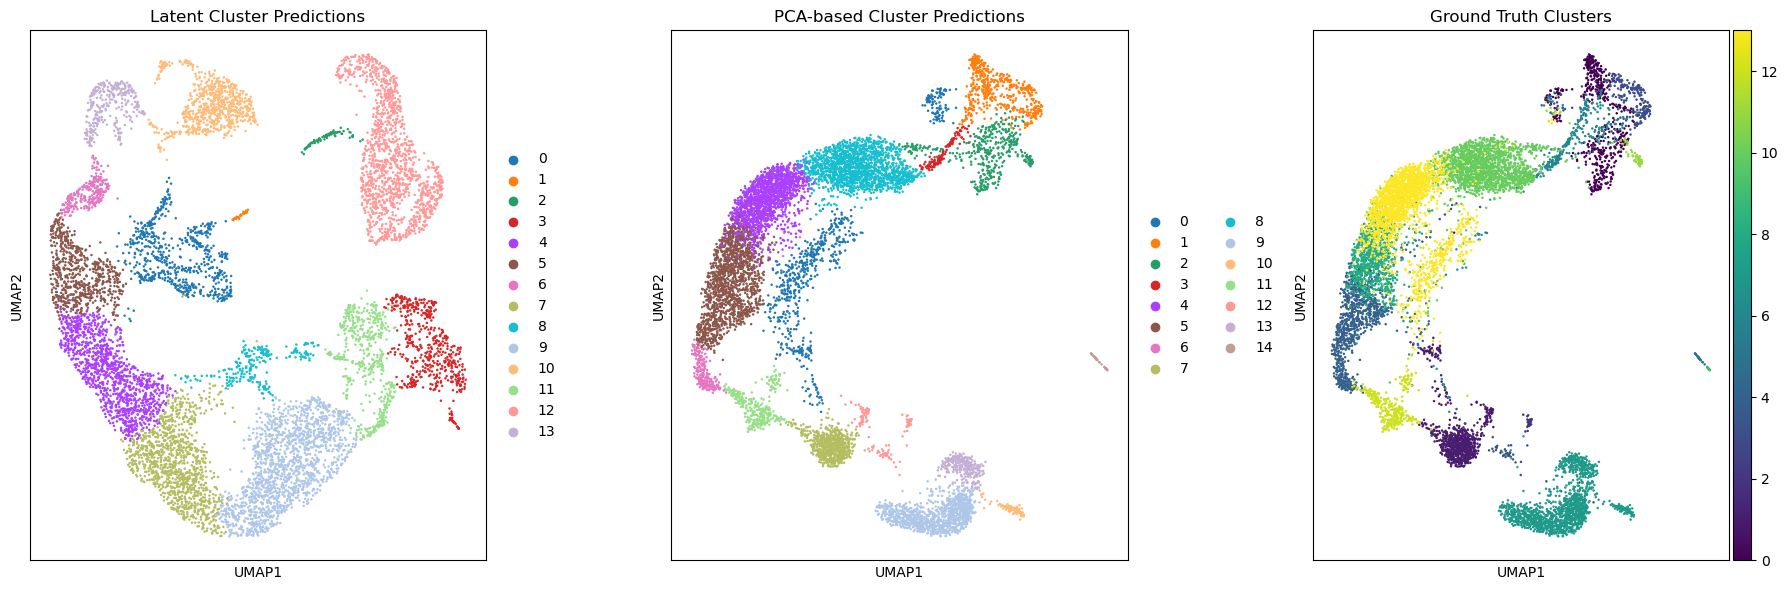

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# leiden clustering on latent representation
sc.pl.umap(adata_latent, color="leiden", ax=ax[0], title="Latent Cluster Predictions", show=False)

# leiden clustering on PCs (same as baseline)
sc.pl.umap(adata, color="leiden", ax=ax[1], title="PCA-based Cluster Predictions", show=False)

# 3. Ground truth labels
sc.pl.umap(adata, color="Group", ax=ax[2], title="Ground Truth Clusters", show=False)

plt.tight_layout()
plt.show()

In [14]:
# this is taking the results of leiden clustering on the latent space and getting n_clusters and cluster_centers
# n_clusters and cluster_centers are used in the clustering phase of the autoencoder below

y_pred_init = np.asarray(adata_latent.obs['leiden'],dtype=int)
features = pd.DataFrame(adata_latent.X,index=np.arange(0,adata_latent.n_obs))
Group = pd.Series(y_pred_init,index=np.arange(0,adata_latent.n_obs),name="Group")
Mergefeature = pd.concat([features,Group],axis=1)
cluster_centers = np.asarray(Mergefeature.groupby("Group").mean())
n_clusters = cluster_centers.shape[0]
print('Estimated number of clusters: ', n_clusters)

Estimated number of clusters:  14


In [15]:
DEVICE = torch.device(device)
EPOCHS = 100
BATCHSIZE = 256
N_TRAIN_EXAMPLES = BATCHSIZE * 5

ORIGINAL_INPUT_SIZE = adata.n_vars
LATENT_SIZE = n_clusters

# dataset = TensorDataset(torch.Tensor(adata.X), torch.Tensor(adata.raw.X), torch.Tensor(adata.obs.size_factor.values))
dataset = TensorDataset(torch.Tensor(adata.X))

def define_model(trial,original_input_size,latent_size):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_enc_layers = trial.suggest_int("n_enc_layers", 2, 6)
    enc_layers = []

    n_dec_layers = trial.suggest_int("n_dec_layers", 2, 6)
    dec_layers = []

    # Generate encoding layers
    in_features = original_input_size
    for i in range(n_enc_layers-1):
        out_features = trial.suggest_int("n_enc_units_l{}".format(i), 4, 512)
        enc_layers.append(nn.Linear(in_features, out_features))
        enc_layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_enc_l{}".format(i), 0.1, 0.5)
        enc_layers.append(nn.Dropout(p))

        in_features = out_features
    
    # Create latent space
    enc_layers.append(nn.Linear(in_features, latent_size))
    enc_layers.append(nn.ReLU())
    p = trial.suggest_float("dropout_enc_l{}".format(n_enc_layers-1), 0.1, 0.5)
    enc_layers.append(nn.Dropout(p))
    in_features = latent_size

    # Generate decoding layers
    for i in range(n_dec_layers-1):
        out_features = trial.suggest_int("n_dec_units_l{}".format(i), 4, 512)
        dec_layers.append(nn.Linear(in_features, out_features))
        dec_layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_dec_l{}".format(i), 0.1, 0.5)
        dec_layers.append(nn.Dropout(p))

        in_features = out_features

    # Set output size to be original input size
    dec_layers.append(nn.Linear(in_features, original_input_size))
    dec_layers.append(nn.ReLU())
    p = trial.suggest_float("dropout_dec_l{}".format(n_dec_layers-1), 0.1, 0.5)
    dec_layers.append(nn.Dropout(p))
    
    # layers = []
    # layers.append(enc_layers)
    # layers.append(dec_layers)
    layers = enc_layers + dec_layers

    return nn.Sequential(*layers)
    # return nn.Sequential(*enc_layers), nn.Sequential(*dec_layers)



def objective(trial):
    # Generate the model.

    original_input_size = ORIGINAL_INPUT_SIZE
    latent_size = LATENT_SIZE
    model = define_model(trial,original_input_size,latent_size).to(DEVICE)
    # encoder, decoder = define_model(trial,original_input_size,latent_size).to(DEVICE)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # dataset = TensorDataset(torch.Tensor(X), torch.Tensor(X_raw), torch.Tensor(size_factor.values))
    dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)

    # Training of the model
    for epoch in range(EPOCHS):
        loss_val = 0
        best_model.train()
        for batch_idx, x_batch in enumerate(dataloader):
            # # Limiting training data for faster epochs.
            # if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #     break

            x_tensor = Variable(x_batch[0]).to(DEVICE)
            # x_raw_tensor = Variable(x_raw_batch).to(DEVICE)
            # sf_tensor = Variable(sf_batch).to(DEVICE)

            # data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            reconstruction = model(x_tensor)
            loss = nn.functional.mse_loss(reconstruction, x_tensor)

            optimizer.zero_grad()
            # output = model(data)
            loss.backward()
            optimizer.step()
            loss_val += loss.detach().item() * len(x_batch)

        trial.report(loss_val, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return loss_val

In [16]:
study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=400, timeout=600)
study.optimize(objective, n_trials=200, n_jobs=1)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-04-12 17:55:48,242] A new study created in memory with name: no-name-315bc24a-a16a-413d-a90e-18d4292a7688
[I 2025-04-12 17:59:42,628] Trial 0 finished with value: 2.149897838118557 and parameters: {'n_enc_layers': 6, 'n_dec_layers': 2, 'n_enc_units_l0': 504, 'dropout_enc_l0': 0.47537392426353675, 'n_enc_units_l1': 115, 'dropout_enc_l1': 0.38730271131967153, 'n_enc_units_l2': 108, 'dropout_enc_l2': 0.45228806020677637, 'n_enc_units_l3': 354, 'dropout_enc_l3': 0.23585343282649648, 'n_enc_units_l4': 206, 'dropout_enc_l4': 0.1391567300118781, 'dropout_enc_l5': 0.2848279984709937, 'n_dec_units_l0': 286, 'dropout_dec_l0': 0.1510667968047939, 'dropout_dec_l1': 0.16503650959563798, 'optimizer': 'Adam', 'lr': 1.9605013418913705e-05}. Best is trial 0 with value: 2.149897838118557.
[I 2025-04-12 18:03:22,720] Trial 1 finished with value: 3.4479292323749036 and parameters: {'n_enc_layers': 5, 'n_dec_layers': 4, 'n_enc_units_l0': 444, 'dropout_enc_l0': 0.41240082662565947, 'n_enc_units_l1':

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  156
  Number of complete trials:  44
Best trial:
  Value:  1.958769648117846
  Params: 
    n_enc_layers: 3
    n_dec_layers: 3
    n_enc_units_l0: 81
    dropout_enc_l0: 0.26295848067792366
    n_enc_units_l1: 430
    dropout_enc_l1: 0.4924759713895524
    dropout_enc_l2: 0.1588544794375099
    n_dec_units_l0: 164
    dropout_dec_l0: 0.31456407171421175
    n_dec_units_l1: 299
    dropout_dec_l1: 0.21977037688078224
    dropout_dec_l2: 0.10009117010811808
    optimizer: RMSprop
    lr: 0.0003317333948225076


In [17]:
best_trial = study.best_trial
best_params = best_trial.params

fixed_trial = optuna.trial.FixedTrial(best_params)
best_model = define_model(fixed_trial, ORIGINAL_INPUT_SIZE, LATENT_SIZE).to(DEVICE)

optimizer_name = best_params["optimizer"]
lr = best_params["lr"]
optimizer = getattr(optim, optimizer_name)(best_model.parameters(), lr=lr)

dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)

# Training of the model
for epoch in range(400):
    loss_val = 0
    model.train()
    for x_batch in dataloader:
        x_tensor = Variable(x_batch[0]).to(DEVICE)
        reconstruction = best_model(x_tensor)
        loss = nn.functional.mse_loss(reconstruction, x_tensor)

        optimizer.zero_grad()
        # output = model(data)
        loss.backward()
        optimizer.step()
        loss_val += loss.detach().item() * len(x_batch)

best_model.eval()

enc_layer_width = 3
encoder_indices = slice(0, best_params['n_enc_layers'] * enc_layer_width)

eval_model = best_model[encoder_indices]
print(eval_model)

Sequential(
  (0): Linear(in_features=15966, out_features=81, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.26295848067792366, inplace=False)
  (3): Linear(in_features=81, out_features=430, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4924759713895524, inplace=False)
  (6): Linear(in_features=430, out_features=14, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1588544794375099, inplace=False)
)


In [18]:
eval_model.eval()

eval_model_pred = np.zeros(adata.n_obs)
# print(eval_model_pred.shape)
for i in range(adata.n_obs):
    # eval_model_pred = eval_model(torch.tensor(adata.X[i]).to(DEVICE)).cpu().detach().numpy()
    # eval_model_pred = eval_model(torch.tensor(adata.X[i]).to(DEVICE)).argmax()
    x_i = torch.tensor(adata.X[i], dtype=torch.float64).to(DEVICE)
    with torch.no_grad():
        output = eval_model(x_i.unsqueeze(0))
        pred_label = output.argmax(dim=1).item()
        eval_model_pred[i] = pred_label

# print(y.shape)
b_ami = np.round(metrics.normalized_mutual_info_score(y, eval_model_pred), 5)
b_ari = np.round(metrics.adjusted_rand_score(y, eval_model_pred), 5)

print('Evaluating cells for best_model: AMI= %.4f, ARI= %.4f' % (b_ami, b_ari))

if os.path.isfile('best_model.pt'):
    torch.load('best_model.pt')
else:
    torch.save(eval_model, 'best_model.pt')

Evaluating cells for best_model: AMI= 0.5141, ARI= 0.3078


In [19]:
y_pred, _, _, _ = model.fit(X=adata.X, X_raw=adata.raw.X, size_factor=adata.obs.size_factors, n_clusters=n_clusters, init_centroid=cluster_centers, 
            y_pred_init=y_pred_init, y=y, num_epochs=300)

Clustering stage


c:\Users\theop\Desktop\Homework\ECE 542\hpo_1\optuna\model.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size_factor = torch.tensor(size_factor, dtype=torch.float64)


Initializing cluster centers with kmeans.
Initializing k-means: AMI= 0.7150, ARI= 0.6493
Clustering   1: AMI= 0.6923, ARI= 0.6200


c:\Users\theop\Desktop\Homework\ECE 542\hpo_1\optuna\model.py:216: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  cluster_loss_val += cluster_loss.item() * len(inputs)


Epoch   1: Total: 0.78181301 Clustering Loss: 0.50795183 ZINB Loss: 0.27386118
Clustering   2: AMI= 0.7133, ARI= 0.6775
Epoch   2: Total: 0.65361039 Clustering Loss: 0.37800617 ZINB Loss: 0.27560422
Clustering   3: AMI= 0.7075, ARI= 0.6678
Epoch   3: Total: 0.57804543 Clustering Loss: 0.30301267 ZINB Loss: 0.27503276
Clustering   4: AMI= 0.6997, ARI= 0.6472
Epoch   4: Total: 0.64259646 Clustering Loss: 0.36675778 ZINB Loss: 0.27583869
Clustering   5: AMI= 0.6965, ARI= 0.6498
Epoch   5: Total: 0.48941618 Clustering Loss: 0.21377052 ZINB Loss: 0.27564567
Clustering   6: AMI= 0.6996, ARI= 0.6458
Epoch   6: Total: 0.64676340 Clustering Loss: 0.37023557 ZINB Loss: 0.27652782
Clustering   7: AMI= 0.6968, ARI= 0.6484
Epoch   7: Total: 0.48965004 Clustering Loss: 0.21339836 ZINB Loss: 0.27625169
Clustering   8: AMI= 0.6968, ARI= 0.6383
Epoch   8: Total: 0.61181020 Clustering Loss: 0.33482526 ZINB Loss: 0.27698494
Clustering   9: AMI= 0.6955, ARI= 0.6423
Epoch   9: Total: 0.51078810 Clustering 

In [20]:
# final metrics

ami = np.round(metrics.normalized_mutual_info_score(y, y_pred), 5)
ari = np.round(metrics.adjusted_rand_score(y, y_pred), 5)
print('Evaluating cells: AMI= %.4f, ARI= %.4f' % (ami, ari))

Evaluating cells: AMI= 0.7023, ARI= 0.6612


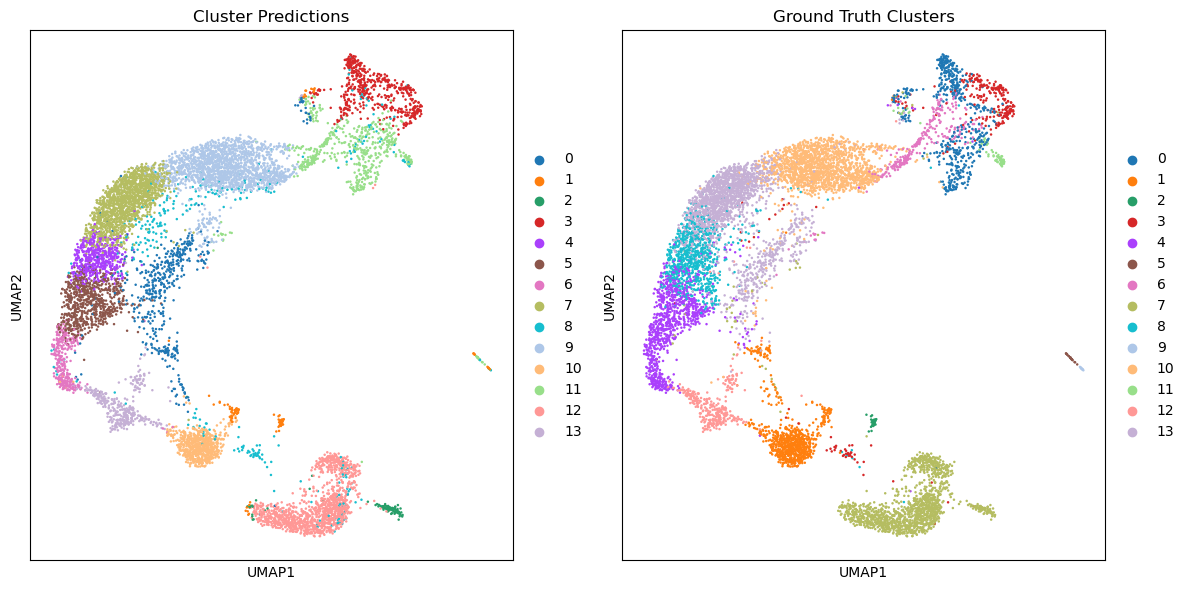

In [21]:
# plot clustering phase results

adata.obs['y_pred'] = y_pred.astype(str)
adata.obs['Group'] = y.astype(str)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Clustering phase predictions
sc.pl.umap(adata, color="y_pred", ax=ax[0], title="Cluster Predictions", show=False)

# Ground truth labels
sc.pl.umap(adata, color="Group", ax=ax[1], title="Ground Truth Clusters", show=False)

plt.tight_layout()
plt.show()